# Part A:
basic flow of the project:
1. downloading the files
2. Making a data frame of the downloaded image
3. Basic data processing like image augmentation, making image pairs and splitting the data into training, testing and validation data sets
4. Defining the model
5. Defining the loss ( Contrastive loss)
6. Training the model on different optimizers and schedulers
7. Testing to test data set
8. Testing on real life images

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import time
import torchvision.transforms as transforms
import random


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using cpu device


In [5]:
# import images from folder and store it in a pandas data frame
path = 'D:\Ashish\OneDrive\Desktop\jupyter notebook\EE 782 assigment 2\lfw-deepfunneled'
files = os.listdir(path)
files = files[:int(0.5*len(files))]
label = []
directory = []
for file in files:
    path_new = path+'\\'+file
    images_path = os.listdir(path_new)
    for image in images_path:
        label.append(file)
        directory.append(image)
data = pd.DataFrame({'label':label, 'directory':directory})
data = data[:int(0.1*(data.shape[0]))]
data.head()

,label,directory
0,Aaron_Eckhart,Aaron_Eckhart_0001.jpg
1,Aaron_Guiel,Aaron_Guiel_0001.jpg
2,Aaron_Patterson,Aaron_Patterson_0001.jpg
3,Aaron_Peirsol,Aaron_Peirsol_0001.jpg
4,Aaron_Peirsol,Aaron_Peirsol_0002.jpg


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      45 non-null     object
 1   directory  45 non-null     object
dtypes: object(2)
memory usage: 848.0+ bytes


In [7]:
# funtion to convert image to numpy array
from keras.preprocessing.image import load_img
def img2vector(data_frame):
    '''input: data frame
       output: numpy array of images, numpy array of images converted to vector'''
    path = 'D:\Ashish\OneDrive\Desktop\jupyter notebook\EE 782 assigment 2\lfw-deepfunneled'
    images_vec = []
    images = []
    for idx in range(0,data_frame.shape[0]):
        person = data_frame['label'][idx]    # extracting the label of the image
        directory = data_frame['directory'][idx]   # extraction the directory of the image
        img_path = path +'\\'+person+'\\'+ directory
        img = load_img(img_path, target_size=(224, 224))   # resizing to 128x128 and converting to grey scale to reduce channels
        images.append(img)
    return images        

In [8]:
images = img2vector(data)   # the vector images contains all the images and images_vec contains images converted to vector
print('shape of images = ', len(images))

shape of images =  45


In [9]:
data['image'] = images
data.head()

,label,directory,image
0,Aaron_Eckhart,Aaron_Eckhart_0001.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...
1,Aaron_Guiel,Aaron_Guiel_0001.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...
2,Aaron_Patterson,Aaron_Patterson_0001.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...
3,Aaron_Peirsol,Aaron_Peirsol_0001.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...
4,Aaron_Peirsol,Aaron_Peirsol_0002.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...


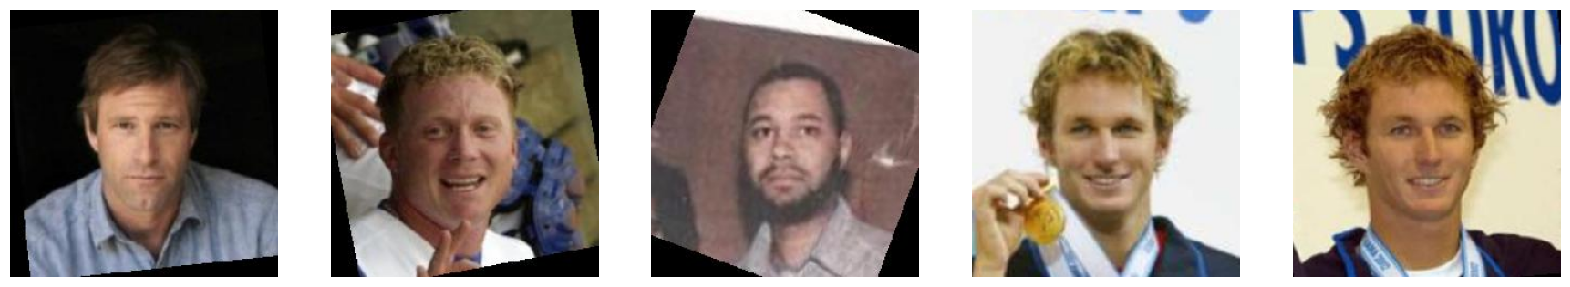

In [10]:
# plottig 5 images from the dataframe
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(data.image[i])
    plt.axis('off')
plt.show()


### Data preprocessing
This has image augmentation, making image pairs and splitting the data set

In [11]:
from torch.utils.data import DataLoader

class data_processor:
    def __init__(self, data_frame) -> None:
        self.data_frame = data_frame

    def augment_image(self, percent):
        # Image Augmentation using torchvision.transforms
        data_transform = transforms.Compose([
                transforms.CenterCrop(size =(224,244)),   # adding random perspective
                transforms.RandomHorizontalFlip(),  # Random horizontal flip
                transforms.RandomRotation(180),  # Random rotation up to 30 degrees
                transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.1, hue=0.3),  # Adjust brightness, contrast, saturation, and hue
                ])
        for i in range (int(percent*(self.data_frame.shape[0]))):   # replace random images with it's augmented image
            idx = random.randint(0,self.data_frame.shape[0]-1)    
            img = self.data_frame.image[idx]
            self.data_frame.image[idx] = data_transform(self.data_frame.image[idx])
        plt.figure(figsize=(15,30))   # plotting augmented an normal image to compare
        plt.subplot(1,5,1)
        plt.axis('off')
        plt.imshow(self.data_frame.image[idx])
        plt.subplot(1,5,2)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        return self.data_frame
    
    def test_train_split(self, percent):   # test train split
        unique_people = self.data_frame.label.unique()    # extracting number of unique personlities
        train_size = int(unique_people.size * percent)   # using a portion for train and rest for test. 
        train_split = unique_people[train_size]
        split_index = self.data_frame.index[self.data_frame['label'] == train_split].max()
        train_df = self.data_frame.iloc[:split_index+1]  # splitting without shuffling so the test set has images never seen by model
        test_df = self.data_frame.iloc[split_index+1:]
        test_df.reset_index(inplace=True)    # reindexing the data sets
        test_df.drop(columns='index', inplace=True)
        return train_df, test_df  

    def mix_match(self, data_frame, num_samples):    # makes pairs of images which vcan either be of the same person or different
        '''input: data frame, num of data pairs we want
            output: data frame with image pairs'''
        img1, img2 = [], []
        label1, label2 = [], []
        is_same = []
        for i in range (num_samples):
            idx1 = random.randint(0,data_frame.shape[0]-2)    # selecting a random index
            # random selection between idx1+1 and idx1+4 to avoid repetation of image and to have almost 50% of the data set with image pair of same person 
            idx2 = random.randint(idx1+1,min(idx1+4,data_frame.shape[0]-1))    
            img1.append(data_frame['image'][idx1])   
            img2.append(data_frame['image'][idx2])
            label1.append(data_frame['label'][idx1])
            label2.append(data_frame['label'][idx2])
            if(label1[-1] == label2[-1]):
                is_same.append(1)      # if image pair is of same person then label it as '1'
            else:
                is_same.append(0)   # else '0'
        
        d = {'label1': label1, 'img1':img1, 'label2':label2, 'img2':img2, 'is_same':is_same}
        data_frame_new = pd.DataFrame(data=d)
        return data_frame_new 

    def validation_data_set(self,train_df):   # chosing randomly 20% of the training data and making validation data set
        '''input: train data frame
            output: validation data frame'''
        val_df = train_df.sample(frac=0.2)
        val_df.reset_index(inplace=True)
        val_df.drop(columns='index', inplace=True)
        return val_df
    
            

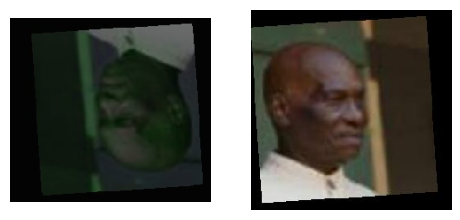

In [12]:
# trying to augment the image. In augmentation I am only considering changing the RGB value, mirroring, centre cropping and rotation.
img_data_processor = data_processor(data)
img_df = img_data_processor.augment_image(0.5)

In [32]:
train_df,test_df = img_data_processor.test_train_split(0.5)
test_img_pair_df = img_data_processor.mix_match(test_df, 75)
train_img_pair_df = img_data_processor.mix_match(train_df, 200)
val_img_pair_df = img_data_processor.validation_data_set(train_img_pair_df)

print('sahpe of test data set = ', test_img_pair_df.shape)
print('shape of train data set = ', train_img_pair_df.shape )
print('shape of validation data set = ', val_img_pair_df.shape)

sahpe of test data set =  (75, 5)
shape of train data set =  (200, 5)
shape of validation data set =  (40, 5)


C:\Users\Suditi\AppData\Local\Temp\ipykernel_4808\2385676662.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns='index', inplace=True)


In [33]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Defining a custom dataset class specific to the sata given
class CustomImageDataset:
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)   # returning the length of the data set

    def __getitem__(self, idx):
        img1 = self.data.iloc[idx,1]     # extracting image pair and label from the data frame
        img2 = self.data.iloc[idx,3]     # extracting image pair and label from the data frame
        label = torch.tensor(self.data.iloc[idx, 4], dtype=torch.float32)   # converting label to tensor

        if self.transform:
            img1 = self.transform(img1)    # converting image pair to tensor
            img2 = self.transform(img2)
        return img1, img2, label

# Defining data transform from PIL (which is in data frame) image to tensor (to feed the model)
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),    # reshaping the image if not previously in the desired shape which is 224 x 224 x 3 
    transforms.ToTensor(),   # converting image to tensor
])

# using Customized data set to make data loader
# Create a DataLoader for batch processing
batch_size = 256

test_dataloader = DataLoader(CustomImageDataset(dataframe=test_img_pair_df, transform=data_transform), batch_size=batch_size, shuffle=False)
train_dataloader = DataLoader(CustomImageDataset(dataframe=train_img_pair_df, transform=data_transform), batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(CustomImageDataset(dataframe=val_img_pair_df, transform=data_transform), batch_size=batch_size, shuffle=False)


In [34]:
# use a pretrained mobilenet_v3_small from torchvision.models and creating a siamese network using it
import torch.nn as nn
import torchvision.models as models


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = models.mobilenet_v3_small(pretrained=True)  # loading the mobile v3 network pretrained on imagenet
        
        # Removing the classification head (fully connected layer) from the model
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])

        # Create the fully connected layer for the Siamese network
        # add regularization to avoid overfitting
        self.fc = nn.Sequential(
            nn.Linear(576, 256),
            nn.Dropout(0.5),   # adding dropout to avoid overfitting
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.2),   # adding dropout to avoid overfitting
            nn.ReLU(),
            nn.Linear(128, 64),
        )

    def forward_one(self, x):
        # Forward pass for a single input
        x = self.base_model(x)
        x = x.view(x.size()[0], -1)   # flattening the output of the base model
        x = self.fc(x)     # passing the flattened output to the fully connected layer
        return x

    def forward(self, input1, input2):
        # Forward pass for two inputs
        output1 = self.forward_one(input1)     # passing the first input to the siamese network
        output2 = self.forward_one(input2)     # passing the second input to the siamese network
        return output1, output2


In [35]:
import torch.nn.functional as F

class ContrastiveLoss(torch.nn.Module):
    '''
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1,output2)    # calculating the euclidean distance between the two outputs
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calculating the loss
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive 

In [36]:
import torch.optim as optim
import torch.optim.lr_scheduler as scheduler

net = SiameseNetwork()   # Declare Siamese Network with dropout probablility to be 0.5
criterion = ContrastiveLoss()   # Decalre Loss Function

c:\Users\Suditi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Suditi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
class Train:
    def __init__(self, siamese_model, test_dl, val_dl, num_epochs, loss):
        self.siamese_model = siamese_model
        self.test_dl = test_dl
        self.val_dl = val_dl
        self.num_epochs = num_epochs
        self.loss = loss

    def eval_validation_loss(self):  # function to evaluate validation loss
        self.siamese_model.eval()
        val_loss = []
        with torch.no_grad():
            for batch, (X1, X2, y) in enumerate(self.val_dl):   # iterating over the validation data set
                pred1, pred2 = self.siamese_model.forward(X1, X2) 
                # pred1, pred2 = pred1.to(device), pred2.to(device), label.to(device)   # moving the data to GPU
                loss = self.loss(pred1, pred2, y)   # calculating loss
            val_loss.append(loss.item())   # appending the loss to a list
        return val_loss

    def train_model(self, optimizer, scheduler=None):    # function to train the model
        val_loss_history = []
        
        for epoch in range(0, self.num_epochs):  # iterating over the number of epochs
            if scheduler:
                scheduler.step()
            for i, data in enumerate(train_dataloader, 0):
                img0, img1, label = data
                img0, img1, label = img0.to(device), img1.to(device), label.to(device)   # moving the data to GPU
                optimizer.zero_grad()   # zeroing the gradients
                output1, output2 = self.siamese_model.forward(img0, img1)  # forward pass
                loss_contrastive = self.loss(output1, output2, label)    # calculating loss
                loss_contrastive.backward()    # backward pass
                optimizer.step()     # updating the weights
            val_loss_history.append(np.mean(self.eval_validation_loss()))     # calculating validation loss
        print("Epoch number {} Final loss {}\n".format(epoch + 1, val_loss_history[-1]))     # printing the final loss

        return self.siamese_model, val_loss_history

In [38]:
# hyper parameters
learning_rate = 0.001
epochs = 35

In [39]:
# RMS propagation optimizer
optimizer1 = optim.SGD(net.parameters(), lr=learning_rate)  # Declare optimizer 1
# Adam optimizer
optimizer2 = optim.Adam(net.parameters(), lr=learning_rate) # Declaring optimizer 2

In [40]:
train_model = Train(net, test_dataloader, val_dataloader, epochs, criterion)
print('model 1: with SGD')
model_opt1, loss_opt1 = train_model.train_model(optimizer1)  # training the model with optimizer 1 which is SGD
print('model 2: with Adam')
model_opt2, loss_opt2 = train_model.train_model(optimizer2)  # training the model with optimizer 2 which is Adam

model 1: with SGD
Epoch number 35 Final loss 0.685782253742218

model 2: with Adam
Epoch number 35 Final loss 0.28426674008369446



In [1]:
x = np.arange(1, epochs+1, 1)
plt.plot(x, loss_opt1, label = 'SGD loss')
plt.plot(x, loss_opt2, label = 'Adam loss')
plt.legend()
plt.show()


NameError: name 'np' is not defined

### Comparision between the optimizers:
1. Clearly adam works better than SGD in this case
2. Adam combines the benefits of AdaGrad and RMSProp, which are designed to handle sparse gradients and adapt learning rates to each parameter individually.
3. In many cases, Adam converges faster, which can save time and resources during training, especially for Siamese networks, where you may need to train multiple pairs of data.

In [42]:
# step learning rate scheduler
scheduler1 = scheduler.StepLR(optimizer2, step_size=2, gamma=0.1)  # Declaring scheduler 1
# cosine annealing scheduler
scheduler2 = scheduler.CosineAnnealingLR(optimizer2, T_max=10, eta_min=0)  # Declaring scheduler 2
print('model1: adam loss with step lr scheduler ')
model_opt_ws1, loss_opt2_ws1 = train_model.train_model(optimizer2, scheduler1)  # step learning rate scheduler
print('model2: adam loss with cosine annealing scheduler ')
model_opt_ws2, loss_opt2_ws2 = train_model.train_model(optimizer2, scheduler2)  # cosine annealing scheduler

model1: adam loss with step lr scheduler 


c:\Users\Suditi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch number 35 Final loss 0.2871849536895752

model2: adam loss with cosine annealing scheduler 
Epoch number 35 Final loss 0.28909483551979065



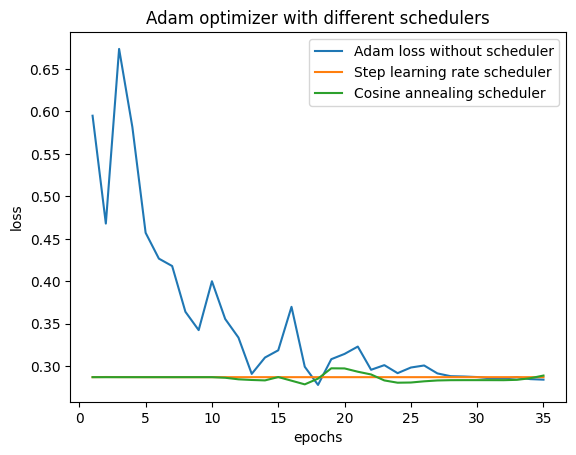

In [43]:
x = np.arange(1, epochs+1, 1)
plt.plot(x, loss_opt2, label = 'Adam loss without scheduler')
plt.plot(x, loss_opt2_ws1, label = 'Step learning rate scheduler')
plt.plot(x, loss_opt2_ws2, label = 'Cosine annealing scheduler')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Adam optimizer with different schedulers')
plt.legend()
plt.show()

### Comparision between Cosine annealing and Step Learning rate
1. Both perform equally well except for the fact that cosine annealing has a bit of a bumpy convergence
2. THis might be because of a an increase in learning rate in case of cosine anealing

In [51]:
# testing the model and printing the accuracy
def test_model(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch, (X1, X2, y) in enumerate(test_dataloader):  # iterating over the test data set
            pred1, pred2 = model.forward(X1, X2)     # forward pass
            pred1, pred2 = pred1.to(device), pred2.to(device)     
            euclidean_distance = F.pairwise_distance(pred1, pred2)      # calculating the euclidean distance between the two outputs
            for i in range(len(euclidean_distance)):    # calculating the accuracy
                if euclidean_distance[i] < 1 and y[i] == 1:    
                    correct += 1
                elif euclidean_distance[i] > 1 and y[i] == 0:
                    correct += 1
                total += 1
        print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


In [53]:
print('model 1: adam loss with step lr scheduler ')
test_model(model_opt_ws1, test_dataloader)
print('model 2: adam loss with cosine annealing scheduler ')
test_model(model_opt_ws2, test_dataloader)

model 1: adam loss with step lr scheduler 
Accuracy of the network on the test images: 69 %
model 2: adam loss with cosine annealing scheduler 
Accuracy of the network on the test images: 69 %


euclidean distance =  0.941283643245697
label =  1.0
correct prediction, i.e true positive


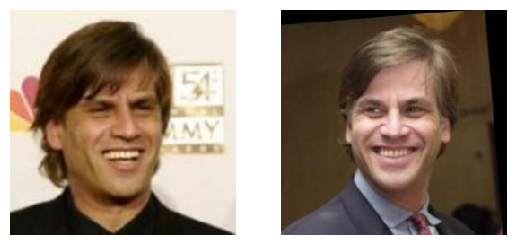

euclidean distance =  0.538227379322052
label =  0.0
wrong prediction i.e false positive


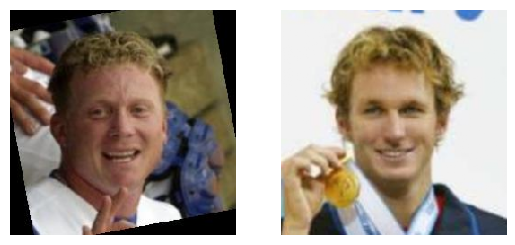

euclidean distance =  0.061430007219314575
label =  0.0
wrong prediction i.e false positive


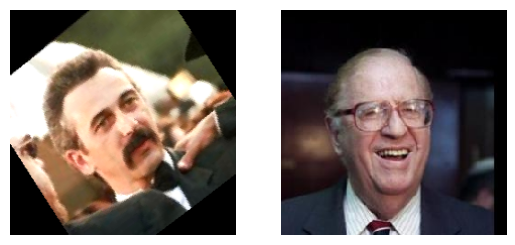

euclidean distance =  0.8399240374565125
label =  0.0
wrong prediction i.e false positive


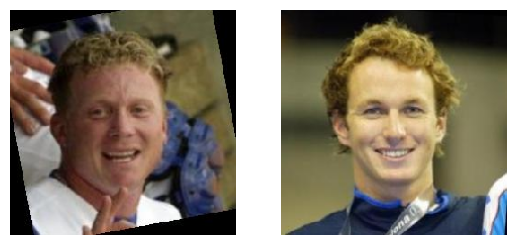

euclidean distance =  0.06865488737821579
label =  0.0
wrong prediction i.e false positive


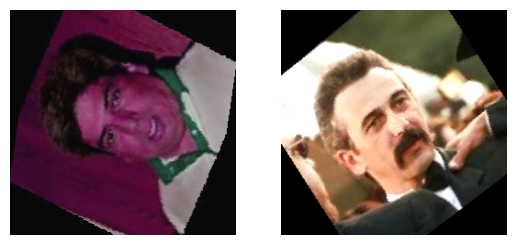

In [63]:
# randomly print 5 image pair from training dat loader and it's euclidean distance and its label
def print_img_pair(train_dataloader):
    for batch, (X1, X2, y) in enumerate(train_dataloader):      
        pred1, pred2 = model_opt_ws2.forward(X1, X2)
        pred1, pred2 = pred1.to(device), pred2.to(device)
        euclidean_distance = F.pairwise_distance(pred1, pred2)
        for i in range(10,15):
            print('euclidean distance = ', euclidean_distance[i].item())
            print('label = ', y[i].item())
            if(y[i].item()==1):
                if(euclidean_distance[i]<1):
                    print('correct prediction, i.e true positive')
                else:
                    print('wrong prediction i.e false negative')
            else:
                if(euclidean_distance[i]>1):
                    print('correct prediction, i.e true negative')
                else:
                    print('wrong prediction i.e false positive')
            plt.subplot(1,2,1)
            plt.imshow(X1[i].permute(1,2,0))
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(X2[i].permute(1,2,0))
            plt.axis('off')
            plt.show()
        break

print_img_pair(train_dataloader)


### Here I have used real images of my friends and a cat to see how the model works

In [102]:
# import images from folder and store it in a pandas data frame
path = 'D:\Ashish\OneDrive\Desktop\ee782 assignment2 pictures'
files = os.listdir(path)
label = []
directory = []
for file in files:
    path_new = path+'\\'+file
    images_path = os.listdir(path_new)
    for image in images_path:
        label.append(file)
        directory.append(image)
data_real = pd.DataFrame({'label':label, 'directory':directory})
data_real.head()

,label,directory
0,Ashish_Prasad,IMG-20220911-WA0008.jpg
1,Ashish_Prasad,IMG-20230815-WA0005.jpg
2,Cat,IMG_20230905_100809.jpg
3,Stuti_Agarwal,IMG-20221025-WA0045.jpg
4,Stuti_Agarwal,IMG-20230924-WA0018.jpg


In [103]:
# funtion to convert image to numpy array
from keras.preprocessing.image import load_img
def img2vector(data_frame):
    '''input: data frame
       output: numpy array of images, numpy array of images converted to vector'''
    path = 'D:\Ashish\OneDrive\Desktop\ee782 assignment2 pictures'
    images = []
    for idx in range(0,data_frame.shape[0]):
        person = data_frame['label'][idx]    # extracting the label of the image
        directory = data_frame['directory'][idx]   # extraction the directory of the image
        img_path = path +'\\'+person+'\\'+ directory
        img = load_img(img_path, target_size=(224, 224))   # resizing to 128x128 and converting to grey scale to reduce channels
        images.append(img)
    return images                  

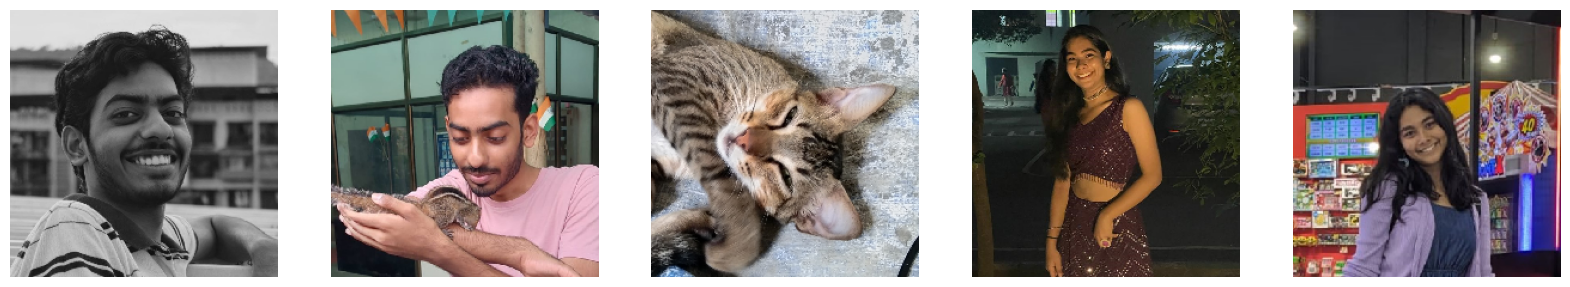

In [104]:
images = img2vector(data_real)   # the vector images contains all the images and images_vec contains images converted to vector
data_real['image'] = images
data_real.drop(columns=['directory'], inplace=True)
# plottig 5 images from the dataframe
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(data_real.image[i])
    plt.axis('off')
plt.show()

In [105]:
data_real.head()

,label,image
0,Ashish_Prasad,<PIL.Image.Image image mode=RGB size=224x224 a...
1,Ashish_Prasad,<PIL.Image.Image image mode=RGB size=224x224 a...
2,Cat,<PIL.Image.Image image mode=RGB size=224x224 a...
3,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...
4,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...


In [109]:
# using the data_real make image pairs and label 1 if image pair is of same person and 0 if not
img_data_processor = data_processor(data_real)
real_img_pair_df = img_data_processor.mix_match(data_real, 15)
real_img_pair_df.head()

,label1,img1,label2,img2,is_same
0,Ashish_Prasad,<PIL.Image.Image image mode=RGB size=224x224 a...,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...,0
1,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...,1
2,Ashish_Prasad,<PIL.Image.Image image mode=RGB size=224x224 a...,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...,0
3,Ashish_Prasad,<PIL.Image.Image image mode=RGB size=224x224 a...,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...,0
4,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...,Stuti_Agarwal,<PIL.Image.Image image mode=RGB size=224x224 a...,1


Accuracy of the network on the test images: 40 %
euclidean distance =  0.3397636115550995
label =  0.0
wrong prediction i.e false positive


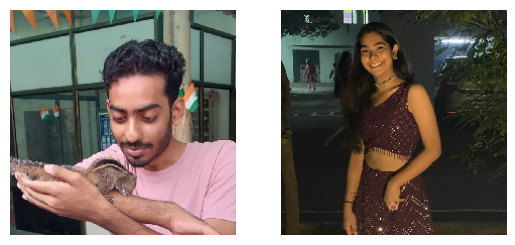

euclidean distance =  0.3737887144088745
label =  1.0
correct prediction, i.e true positive


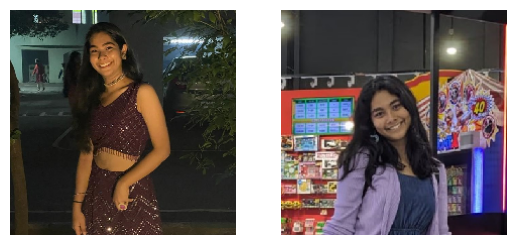

euclidean distance =  0.16377945244312286
label =  0.0
wrong prediction i.e false positive


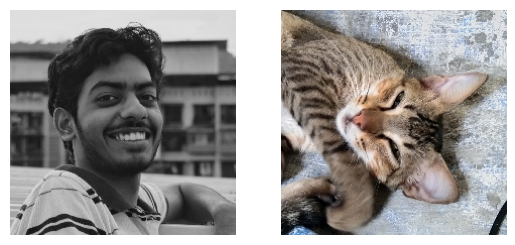

euclidean distance =  0.3737887144088745
label =  1.0
correct prediction, i.e true positive


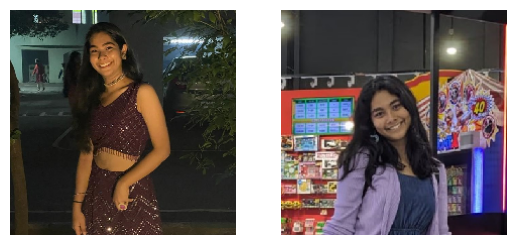

euclidean distance =  0.21096672117710114
label =  0.0
wrong prediction i.e false positive


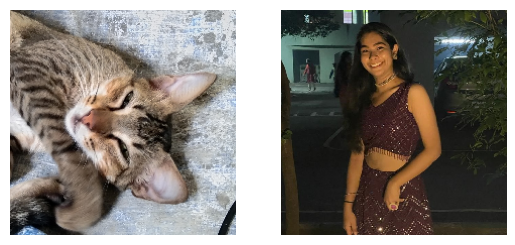

In [110]:
# make a data loader for the real data set and feed it to the model and print accuracy and euclidean distance
real_dataloader = DataLoader(CustomImageDataset(dataframe=real_img_pair_df, transform=data_transform), batch_size=batch_size, shuffle=False)
test_model(model_opt_ws2, real_dataloader)
print_img_pair(real_dataloader)


## References
1. https://www.kaggle.com/code/robinreni/signature-classification-using-siamese-pytorch
2. https://www.kaggle.com/code/jiangstein/a-very-simple-siamese-network-in-pytorch
3. https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html